# EDA

## IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from datetime import datetime

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import StandardScaler

import turicreate as tc
from turicreate import SFrame, SArray

## LOADING DATA

In [2]:
games = pd.read_csv('games.csv', index_col=0)
users = pd.read_csv('user_raiting_games.csv', index_col=0, low_memory=False)
categories = pd.read_csv('df_types.csv', index_col=0)

Ознакомимся с данными по играм в датафрейме games.

In [3]:
games.sample(3)

,id,teseraId,bggId,title,alias,descriptionShort,description,modificationDateUtc,creationDateUtc,photoUrl,...,playersAgeMin,timeToLearn,playtimeMin,playtimeMax,commentsTotal,commentsTotalNew,isAddition,id_type,title2,title3
21740,35501,1547376,255512,The Ghosts Betwixt,the-ghosts-betwixt,Кооперативный тактический данжен-кроулер про п...,<p>Кооперативный тактический данжен-кроулер пр...,2022-02-23T15:52:23,2019-10-23T17:32:15,"https://s.tesera.ru/images/items/1547376,3/200...",...,10,0,90,180,0,0,False,127,NaN,NaN
21959,32630,1350517,242705,Aeon Trespass: Odyssey,aeon-trespass-odyssey,Aeon Trespass: Odyssey - игра в сеттинге мифол...,<p>Aeon Trespass: Odyssey - игра в сеттинге ми...,2023-01-24T17:39:57,2018-11-27T19:10:27,"https://s.tesera.ru/images/items/1350517,3/200...",...,12,0,90,0,345,0,False,127,NaN,NaN
2697,33975,1428738,0,Full Metal Planète,Full-Metal-Planete,В этой научно-фантастической игре о добыче пол...,<p>В этой научно-фантастической игре о добыче ...,2020-05-06T20:38:14,2019-03-26T08:55:59,"https://s.tesera.ru/images/items/1428738,3/200...",...,12,0,90,180,0,0,False,42,NaN,Full Metal Planete


In [4]:
games.shape

(76041, 32)

In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76041 entries, 0 to 76040
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   76041 non-null  int64  
 1   teseraId             76041 non-null  int64  
 2   bggId                76041 non-null  int64  
 3   title                76041 non-null  object 
 4   alias                76041 non-null  object 
 5   descriptionShort     62749 non-null  object 
 6   description          62566 non-null  object 
 7   modificationDateUtc  76041 non-null  object 
 8   creationDateUtc      76041 non-null  object 
 9   photoUrl             75749 non-null  object 
 10  year                 76041 non-null  int64  
 11  ratingUser           76041 non-null  float64
 12  n10Rating            76041 non-null  float64
 13  n20Rating            76041 non-null  float64
 14  bggRating            76041 non-null  float64
 15  bggGeekRating        76041 non-null 

- 'id' - идентификатор
- 'teseraId' - идентификатор игры tesera.ru
- 'bggId' - идентификатор игры boardgamegeek.com
- 'title' - название игры (локализованные игры обозначены на русском языке)
- 'alias' - "псевдоним" игры, на tesera.ru используется как id
- 'descriptionShort' - короткое описание игры
- 'description' - описание игры
- 'modificationDateUtc' - дата последнего внесения изменений tesera.ru
- 'creationDateUtc' - дата создания на tesera.ru
- 'photoUrl' - url фотографий
- 'year' - год выпуска игры
- 'ratingUser' - средний рейтинг игры на tesera.ru
- 'n10Rating' - нет данных
- 'n20Rating' - нет данных
- 'bggRating' - редний рейтинг игры на boardgamegeek.com
- 'bggGeekRating' - 
- 'bggNumVotes' - количество голосов на boardgamegeek.com
- 'numVotes' - нет данных
- 'playersMin' - минимальное количество игроков по правилам
- 'playersMax' - максимальное количество игроков по правилам
- 'playersMinRecommend' - минимальное количество игроков по мнению игроков
- 'playersMaxRecommend' - максимальное количество игроков по мнению игроков
- 'playersAgeMin' - минимальный возраст игроков
- 'timeToLearn' - время освоения
- 'playtimeMin' - минимальное время для партии
- 'playtimeMax' - максимальное время для партии
- 'commentsTotal' - количетсво комментариев к игре
- 'commentsTotalNew' - количетсво новых комментариев к игре
- 'isAddition' - True - является дополнением к игре, False - самостоятельная игра
- 'id_type' - id категории игры
- 'title2' - нет данных
- 'title3' - нет данных

В данных есть пропуски и пустые значения (Nan). В некоторых столбцах необходимо изменить тип данных.

In [6]:
users.head(3)

,creationDateUtc,rating,game_alias,author.teseraId,author.id,author.login,author.name,author.rating,author.teseraUrl,author.avatarUrl,comment
0,2023-01-27T07:17:05.816808,6.00,jinx,303746,6623,greyve,Ник,3387,https://tesera.ru/user/303746,NaN,NaN
1,2023-01-19T08:07:44,9.50,warhammer-underworlds-gnarlwood,530973,12169,fateweaver,Fateweaver,412,https://tesera.ru/user/530973,"https://s.tesera.ru/images/items/530973,22/pho...",NaN
2,2023-02-10T10:45:19.123895,6.25,epichnyye-skhvatki-boyevykh-magov-krutagidon-e...,1339152,37465,proton1,Даниил,181,https://tesera.ru/user/1339152,"https://s.tesera.ru/images/items/1339152,22/ph...",NaN


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390467 entries, 0 to 390466
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   creationDateUtc   390467 non-null  object 
 1   rating            390467 non-null  float64
 2   game_alias        390467 non-null  object 
 3   author.teseraId   390467 non-null  int64  
 4   author.id         390467 non-null  int64  
 5   author.login      390461 non-null  object 
 6   author.name       390467 non-null  object 
 7   author.rating     390467 non-null  int64  
 8   author.teseraUrl  390467 non-null  object 
 9   author.avatarUrl  309285 non-null  object 
 10  comment           7 non-null       object 
dtypes: float64(1), int64(3), object(7)
memory usage: 35.7+ MB


- 'creationDateUtc' - дата регистарции юзера
- 'rating' - оценка которую поставил юзер игре
- 'game_alias' - псевдоним игры на tesera.ru
- 'author.teseraId' - идентификатор юзера на tesera.ru
- 'author.id' - идентификатор юзера 
- 'author.login' - никнейм юзера
- 'author.name' - имя юзера
- 'author.rating' - рейтинг юзера
- 'author.teseraUrl' - Url на страницу юзера
- 'author.avatarUrl' - Url фотографии
- 'comment' - коментарии

В датафрейме можно удалить столбцы с пропусками

In [8]:
categories.head(3)

,id,name,parentId
0,31,Азартные,NaN
1,42,Война,NaN
2,30,Карты,NaN


In [9]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 45
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        87 non-null     int64  
 1   name      87 non-null     object 
 2   parentId  33 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ KB


В данный датафрейм представляет из себя название, id категорий (тип/сеттинг) игр. Некоторые категории имеют подкатегории (parentId).

## DATA CLEANING

Перед чисткой данных от аномалий, вбросов, пропусков, добавляю в датафрейм games название категорий игр.
Так как при парсинге данных я добавляла столбец с id категории, а одна игра может относится к нескольким категориям сразу соответственно есть явные дубликаты.

In [10]:
# переименую название столбца по которуму будет объединение 

categories = categories.rename(columns={'id': 'id_type'})

In [11]:
games = pd.merge(games, categories, on='id_type')

In [12]:
# объединение категорий (если их несколько) в одну строку для каждой игры
games_new = games.groupby('teseraId')['name'].apply(lambda x: ','.join(map(str, x))).reset_index(name='category')

In [13]:
# удаляю дубликаты по teseraId
games = pd.merge(games.drop_duplicates(subset='teseraId'), games_new, on='teseraId')

In [14]:
games.shape

(18618, 35)

Всего 18 618 игр

In [15]:
# Проверю наличие пустых значений в датафрейме

games.isna().sum()

id                         0
teseraId                   0
bggId                      0
title                      0
alias                      0
descriptionShort        3946
description             4000
modificationDateUtc        0
creationDateUtc            0
photoUrl                  84
year                       0
ratingUser                 0
n10Rating                  0
n20Rating                  0
bggRating                  0
bggGeekRating              0
bggNumVotes                0
numVotes                   0
playersMin                 0
playersMax                 0
playersMinRecommend        0
playersMaxRecommend        0
playersAgeMin              0
timeToLearn                0
playtimeMin                0
playtimeMax                0
commentsTotal              0
commentsTotalNew           0
isAddition                 0
id_type                    0
title2                 13577
title3                 15745
name                       0
parentId               18618
category      

In [16]:
games[games['title2'].notna()].sample(2)

,id,teseraId,bggId,title,alias,descriptionShort,description,modificationDateUtc,creationDateUtc,photoUrl,...,playtimeMax,commentsTotal,commentsTotalNew,isAddition,id_type,title2,title3,name,parentId,category
11224,2829,46894,117,Tayu,Tayu,Ta Yü — абстрактная стратегия на построение ма...,<p>Ta Yü — абстрактная стратегия на построение...,2022-08-29T18:20:57,2011-06-08T20:52:10,"https://s.tesera.ru/images/items/46894,3/200x2...",...,60,4,0,False,41,Ta Yü,Tayü,Логические,NaN,"Логические,фигуры,абстрактная,восточная"
8748,723,5918,20761,До Таллина даЛЛеко?,Do-Tallina-Dalleko,«До Таллина даЛЛеко?» — карточная игра географ...,<p>&laquo;До Таллина даЛЛеко?&raquo;&nbsp;&mda...,2019-12-05T11:39:06,2010-07-05T07:11:42,"https://s.tesera.ru/images/items/5918,3/200x20...",...,0,3,0,False,30,Ausgerechnet Buxtehude,"Belgozoom, Kde leží Kotěhůlky?",Карты,NaN,"Карты,Компанейские,викторины,со специальными к..."


Пропусков в столбцах title2, title3 довольно много, в них указано название игры на других языках, поэтому столбцы можно удалить. Ссылки photoUrl и подкатегории parentId для проекта не понадобятся. Строки с пропусками в описании придется тоже удалить.

In [17]:
# настрока вывода
pd.set_option('display.max_columns', 23)

In [18]:
games.describe()

,id,teseraId,bggId,year,ratingUser,n10Rating,n20Rating,bggRating,bggGeekRating,bggNumVotes,numVotes,playersMin,playersMax,playersMinRecommend,playersMaxRecommend,playersAgeMin,timeToLearn,playtimeMin,playtimeMax,commentsTotal,commentsTotalNew,id_type,parentId
count,18618.000000,1.861800e+04,1.861800e+04,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.000000,18618.0,18618.000000,0.0
mean,20020.253035,9.801379e+05,9.346188e+04,1768.644591,4.427385,1.416253,0.945399,3.773097,2.867497,1084.372543,20.074713,1.715813,4.616554,1.245569,1.937802,9.109679,6.926308,36.975078,58.494145,14.600978,0.0,119.466860,NaN
std,15575.257900,7.160576e+05,2.467147e+05,658.017750,3.450636,2.727515,2.329728,3.535102,2.993901,4795.550599,86.287543,0.855122,6.756214,1.632169,4.621728,4.764881,21.258421,42.624004,82.874296,105.270432,0.0,553.815484,NaN
min,1.000000,1.100000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,25.000000,NaN
25%,5910.250000,2.834545e+05,0.000000e+00,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,7.000000,0.000000,10.000000,0.000000,0.000000,0.0,31.000000,NaN
50%,13181.500000,9.599430e+05,1.016550e+04,2014.000000,6.000000,0.000000,0.000000,5.670500,0.000000,18.000000,2.000000,2.000000,4.000000,0.000000,0.000000,10.000000,0.000000,30.000000,40.000000,0.000000,0.0,42.000000,NaN
75%,36459.750000,1.617278e+06,1.761842e+05,2019.000000,7.340000,0.000000,0.000000,7.090000,5.719000,427.750000,7.000000,2.000000,6.000000,2.000000,4.000000,13.000000,10.000000,50.000000,90.000000,3.000000,0.0,93.000000,NaN
max,45231.000000,2.193739e+06,2.657869e+07,2921.000000,10.000000,8.770000,8.720000,10.000000,8.439000,117442.000000,2139.000000,12.000000,99.000000,30.000000,99.000000,80.000000,999.000000,999.000000,999.000000,4992.000000,0.0,8198.000000,NaN


In [19]:
# В числовых данных довольно много нулевых значений, более детально рассмотрю на графиках Turi create

colsumns_data = games.describe().columns
dataset = games.copy()
dataset = dataset[colsumns_data].drop(columns=['id','teseraId','bggId'])

In [20]:
sf_plot = SFrame(data=dataset)
sf_plot.show()

Materializing SFrame

в столбцах n10Rating, n20Rating, playersMinRecommend, playersMaxRecommend, timeToLearn, playtimeMax
commentsTotalNew медианное значение равно 0 - значит можно удалить тк они малоинформативны.

<AxesSubplot:xlabel='year', ylabel='Density'>

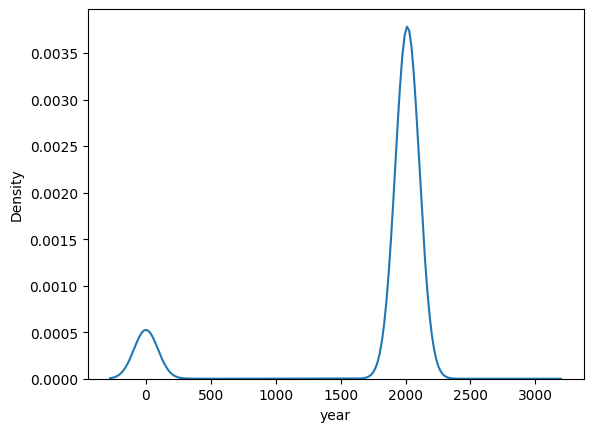

In [21]:
# распределение данных по годам выпуска игр 

sns.kdeplot(data=games['year'])

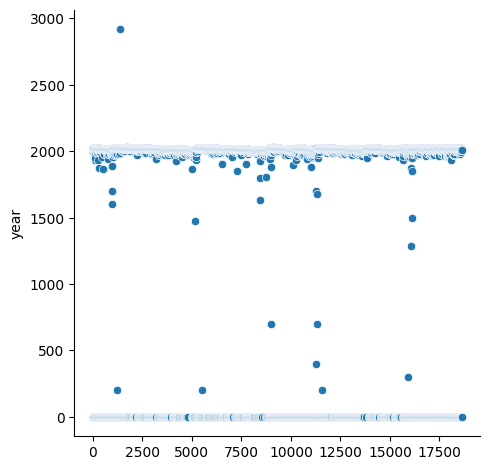

In [22]:
sns.relplot(data=games['year'])

In [23]:
games[games['year'] <= 1850]['year'].value_counts().sort_values(ascending=False)

0       2257
202        3
1700       2
700        2
1600       1
1          1
1475       1
1630       1
1802       1
1810       1
400        1
1680       1
300        1
1283       1
1500       1
1850       1
Name: year, dtype: int64

Фанфакт. Самая старейшая настольная игра 300 года - Тафл (tafl).
Нулевые значения заполню медианным значением.

In [24]:
games['year'].sort_values(ascending=False)

1360     2921
9115     2029
1726     2029
1047     2025
11391    2024
         ... 
10889       0
10890       0
10893       0
10898       0
18617       0
Name: year, Length: 18618, dtype: int64

In [25]:
games['year'] = games['year'].replace(2921, 2021)

В датафрейме есть также игры которые только ожидаются. Игра от 2921 была ошибочно записана, настоящий год выпуска 2019.

Проверю наличие явных дубликатов в датафреймах

In [26]:
games.duplicated().sum()

0

In [27]:
users.duplicated().sum()

1514

In [28]:
#удаляю дубликаты

users = users.drop_duplicates()

In [29]:
# посмотрю сколько уникальных юзеров в датафрейме

users['author.id'].nunique()

11791

In [30]:
# сколько всего игр оценили

users['game_alias'].nunique()

14711

В датафрейме games несколько столбцов подлежат удалению из-за большого количества нулевых значений. 

- всего игр в датасете games - 18 618
- всего юзеров в датасете users - 11 791
- всего оцененных игр - 14 711

## DATA EXPLORATION

### игры с высоким рейтингом

In [31]:
# рассмотрим игры по рейтингу пользователей tesera.ru

games['ratingUser'].describe()

count    18618.000000
mean         4.427385
std          3.450636
min          0.000000
25%          0.000000
50%          6.000000
75%          7.340000
max         10.000000
Name: ratingUser, dtype: float64

In [32]:
games.query('ratingUser == 10')

,id,teseraId,bggId,title,alias,descriptionShort,description,modificationDateUtc,creationDateUtc,photoUrl,year,...,playtimeMin,playtimeMax,commentsTotal,commentsTotalNew,isAddition,id_type,title2,title3,name,parentId,category
92,41107,1993451,0,Кайтэн-Дзуси,kaitenzushi-travel,"Добро пожаловать в ресторан ""Кайтэн-дзуси"", гд...","<p>Добро пожаловать в ресторан ""Кайтэн-дзуси"",...",2021-12-10T12:58:30,2021-12-10T11:27:54,"https://s.tesera.ru/images/items/1993451,3/200...",2021,...,30,40,0,0,False,31,Дорожная версия,NaN,Азартные,NaN,"Азартные,Компанейские,реакция и координация,ка..."
206,38293,1772613,295617,Пей! Пей! Пей!,peipeipei,Пей! Пей! Пей! – это больше двухсот веселых за...,<p>&nbsp;</p>\r\n<p><strong>Пей! Пей! Пей!</st...,2022-04-06T13:45:36,2020-11-09T14:58:36,"https://s.tesera.ru/images/items/1772613,3/200...",2020,...,15,0,0,0,False,31,Drink Drank Drunk: The Game of Mis-Beer-Having,NaN,Азартные,NaN,"Азартные,карты,юмор"
235,37736,1731949,0,Мир чудес,mir-chudes,NaN,NaN,2020-08-28T05:14:25,2020-08-28T05:06:33,"https://s.tesera.ru/images/items/1731949,3/200...",1997,...,0,0,0,0,False,31,NaN,NaN,Азартные,NaN,"Азартные,Война,Карты,Классика,Компанейские,Лог..."
273,37088,1679530,0,Арифмемори,arifmemori,Тренируем память и считаем в уме играючи!,<p>Быстро считать в уме &ndash; это просто! В ...,2021-04-07T19:00:12,2020-05-23T11:58:06,"https://s.tesera.ru/images/items/1679530,3/200...",2020,...,15,0,0,0,False,31,NaN,NaN,Азартные,NaN,"Азартные,Карты,карты,со специальными колодами,..."
292,36685,1639363,281073,Cat Lady: Premium Edition,cat-lady-premium-edition,NaN,NaN,2020-03-17T18:53:55,2020-03-17T18:52:51,"https://s.tesera.ru/images/items/1639363,3/200...",2019,...,15,30,0,0,False,31,NaN,NaN,Азартные,NaN,"Азартные,карты,животные / природа"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18242,29613,1262413,0,Ticket to Ride: Character Score Markers,ticket-to-ride-character-score-markers,NaN,NaN,2018-08-30T08:38:54,2018-05-30T06:11:48,"https://s.tesera.ru/images/items/1262413,3/200...",2013,...,0,0,0,0,False,75,NaN,NaN,транспорт,NaN,транспорт
18302,10337,689511,0,Frankenstein's Bodies,frankensteins-bodies,NaN,NaN,2018-01-24T20:46:45,2016-01-11T11:09:17,"https://s.tesera.ru/images/items/689511,3/200x...",2014,...,0,60,3,0,False,85,NaN,NaN,ужасы,NaN,ужасы
18355,43618,2117043,0,Legends of Andor: The Cold Eternal,legends-of-andor-the-cold-eternal,Действие The Cold Eternal разворачивается в ве...,<p>Действие <strong><i>The Cold Eternal</i> </...,2023-01-31T22:24:02,2022-08-05T00:36:16,"https://s.tesera.ru/images/items/2117043,3/200...",2022,...,60,90,3,0,False,28,NaN,Die Legenden von Andor: Die Ewige Kälte,фэнтези,NaN,фэнтези
18372,41969,2030707,353677,Darkest Doom,darkest-doom,Darkest Doom — это соревновательная стратегиче...,<p><strong><i>Darkest Doom</i></strong> &mdash...,2022-11-29T08:28:32,2022-02-06T02:22:47,"https://s.tesera.ru/images/items/2030707,3/200...",2023,...,90,120,46,0,False,28,NaN,NaN,фэнтези,NaN,фэнтези


207 игр имеют наивысший рейтинг

### игры которые чаще всего оценивают

In [33]:
# Игры которые чаще всего оценивают

pivot = pd.pivot_table(users, values= 'rating', index='game_alias',
                    aggfunc={'rating': [np.mean, 'count']})

pivot.sort_values(by='count', ascending=False).head(15)

,count,mean
game_alias,,
carcassonne,2138,7.520463
terraforming-mars,1980,8.525000
citadels,1914,7.307732
munchkin,1810,5.929972
7-wonders-duel,1761,8.337024
the-settlers-of-catan,1750,7.146429
ticket-ride-europe,1743,7.713999
7-wonders,1681,8.186347
Eldritch-Horror,1648,8.196602


Топ 15 самых оцененных игр на tesera.ru. Игру Каркассон (Carcassonne) оценило 2138 человек.
Игра Покорение Марса (terraforming-mars) - моя любимая =)

In [34]:
# отфильтрую по количеству оценок - показывать игры которые оценили свыше 20 юзеров

pivot.query('count > 20').sort_values(by='mean', ascending=False).head(15)

,count,mean
game_alias,,
twilight-imperium-fourth-edition-prophecy-of-kings,76,9.144737
spirit-island-the-jagged-earth,39,9.108974
Feast-Odin-First-Expansion,34,8.941176
mage-knight-ultimate-edition,366,8.870902
Root-the-exiles-and-partisans-deck,23,8.858696
pax-renaissance-second-edition,103,8.854369
twilight-imperium-fourth-edition,510,8.836275
forbidden-stars-forgotten-worlds,21,8.833333
nemesis-aftermath,27,8.824074


Получается игра с самой высокой средней оценкой - Осквернённый Грааль. Кампании «Эпоха легенд» и «Последний рыцарь»
(Tainted Grail: Age of Legends & Last Knight Campaigns)

###  сколько игр оценивают пользователи

In [35]:
# Теперь посмотрим сколько игр оценивает 1 юзер

coutn_rat_user = users.groupby('author.teseraId')['rating'].agg('count').sort_values(ascending=False)
coutn_rat_user.head(15)

author.teseraId
195924     2095
1473870    1756
615195     1708
1146444    1438
47762      1256
387934     1189
333437     1139
179781     1132
1907513    1119
6924       1118
303746      906
15105       903
767703      848
27978       846
635684      833
Name: rating, dtype: int64

Больше всех игр оценил пользователь с author.teseraId 195924 аж 2095!

Распределение количества оценок по юзерам

### распределение количества оценок по юзерам

In [36]:
user_count = users.groupby('author.teseraId').count()[['game_alias']]

(0.0, 250.0)

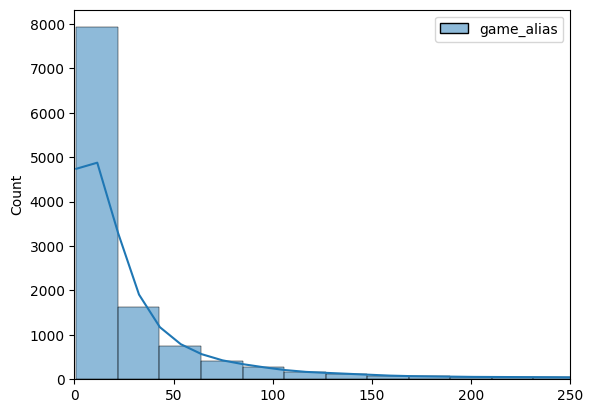

In [37]:
r = sns.histplot(data=user_count, kde=True, bins=100)
r.set_xlim([0, 250])

In [38]:
user_count.describe()

,game_alias
count,11791.000000
mean,32.987278
std,78.874750
min,1.000000
25%,2.000000
50%,10.000000
75%,31.000000
max,2095.000000


В основном пользователи оценивали до 30 игр.

### дополнения к играм

In [39]:
games['isAddition'].value_counts()

False    13234
True      5384
Name: isAddition, dtype: int64

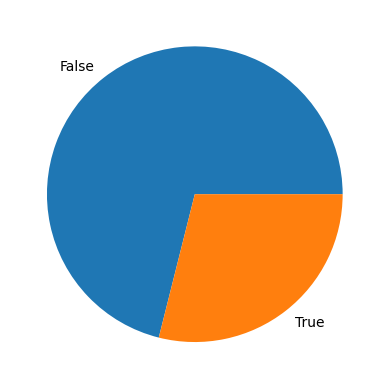

In [40]:
# сколько всего дополнений в датасете games

fig1, ax1 = plt.subplots()
ax1.pie(games['isAddition'].value_counts(), 
        labels=games['isAddition'].unique())
plt.show()

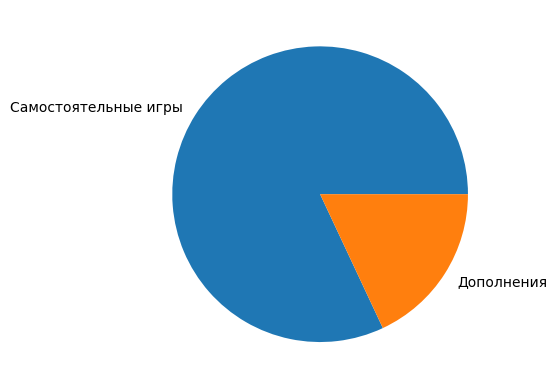

In [41]:
# есть оценки у дополнений, если да, то сколько?

adds = games.query('isAddition==True')['alias']

fig1, ax1 = plt.subplots()
labels = ['Самостоятельные игры', 'Дополнения']
ax1.pie(users['game_alias'].isin(adds).value_counts(), 
        labels = labels)
plt.show()

In [42]:
users['game_alias'].isin(adds).value_counts()

False    318845
True      70108
Name: game_alias, dtype: int64

40% игр в датасете games явяляются дополнениями, 22% от оцененных игр в users - дополнения.

### категории игр

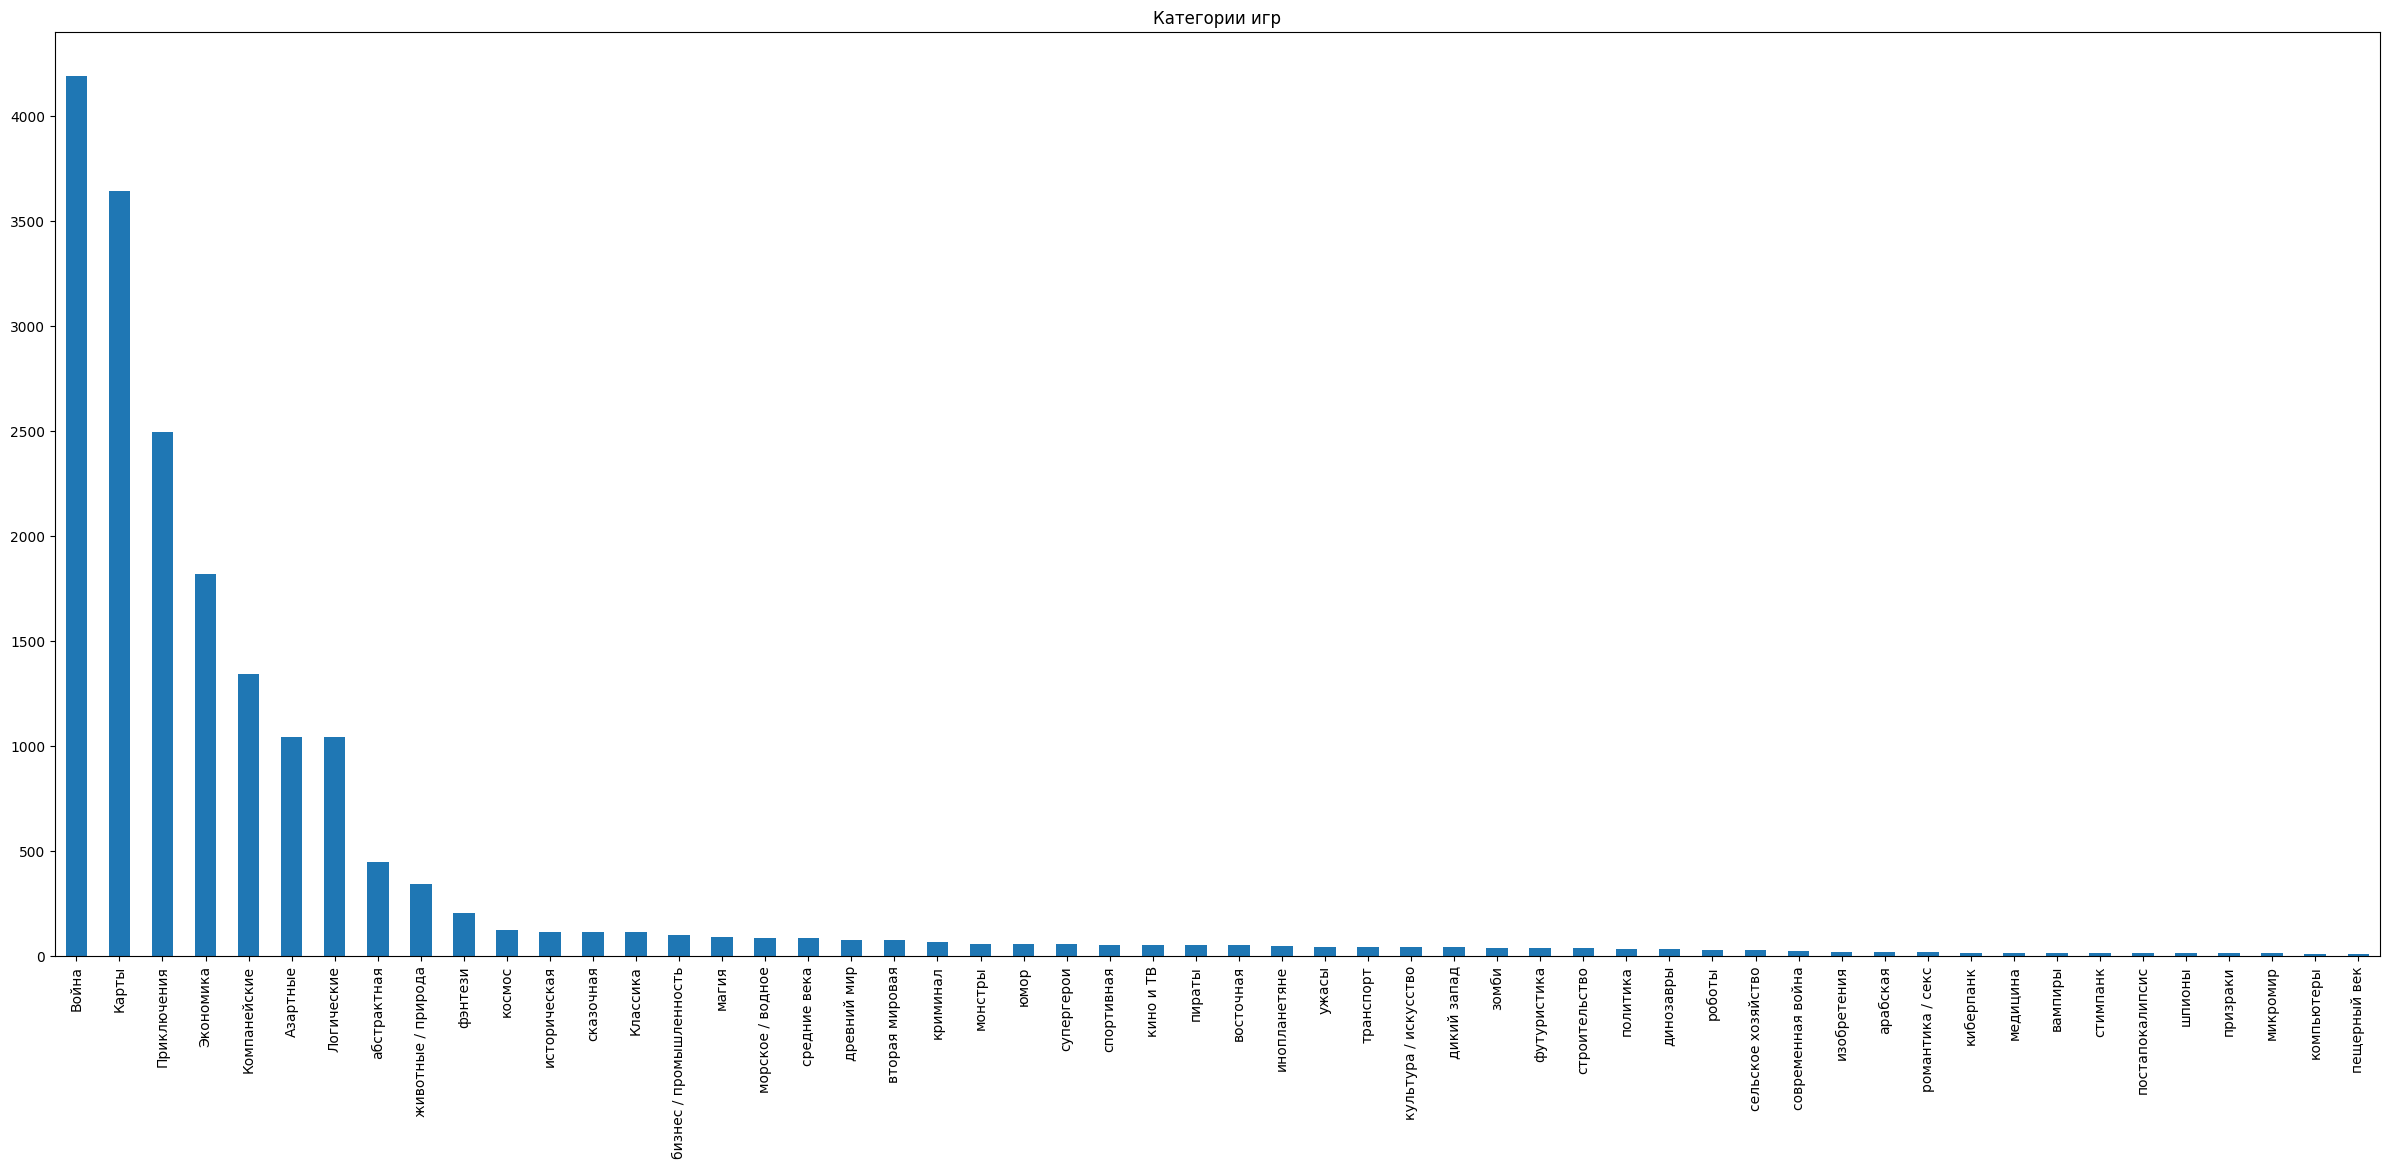

In [44]:
# Распределение игр по категориям, типам

games['name'].value_counts().plot(kind='bar')
plt.title('Категории игр')
plt.rcParams['figure.figsize'] = (30,12)
plt.show()

Больше всего игр в категории война, карты, приключения, экономика.

## DATA PREPROCESSING

### изменение типов данных

In [45]:
# привожу дату создания игры в формат даты, булевое значение в int

games['creationDateUtc'] = pd.to_datetime(games['creationDateUtc']).dt.date
games['isAddition'] = games['isAddition'].astype('int')

###  создание фичей

In [46]:
# создаю новый признак - количество дней со дня публикации игры

today = datetime.today().date()
games['days_count'] = (today - games['creationDateUtc']).dt.days

<AxesSubplot:xlabel='days_count', ylabel='Count'>

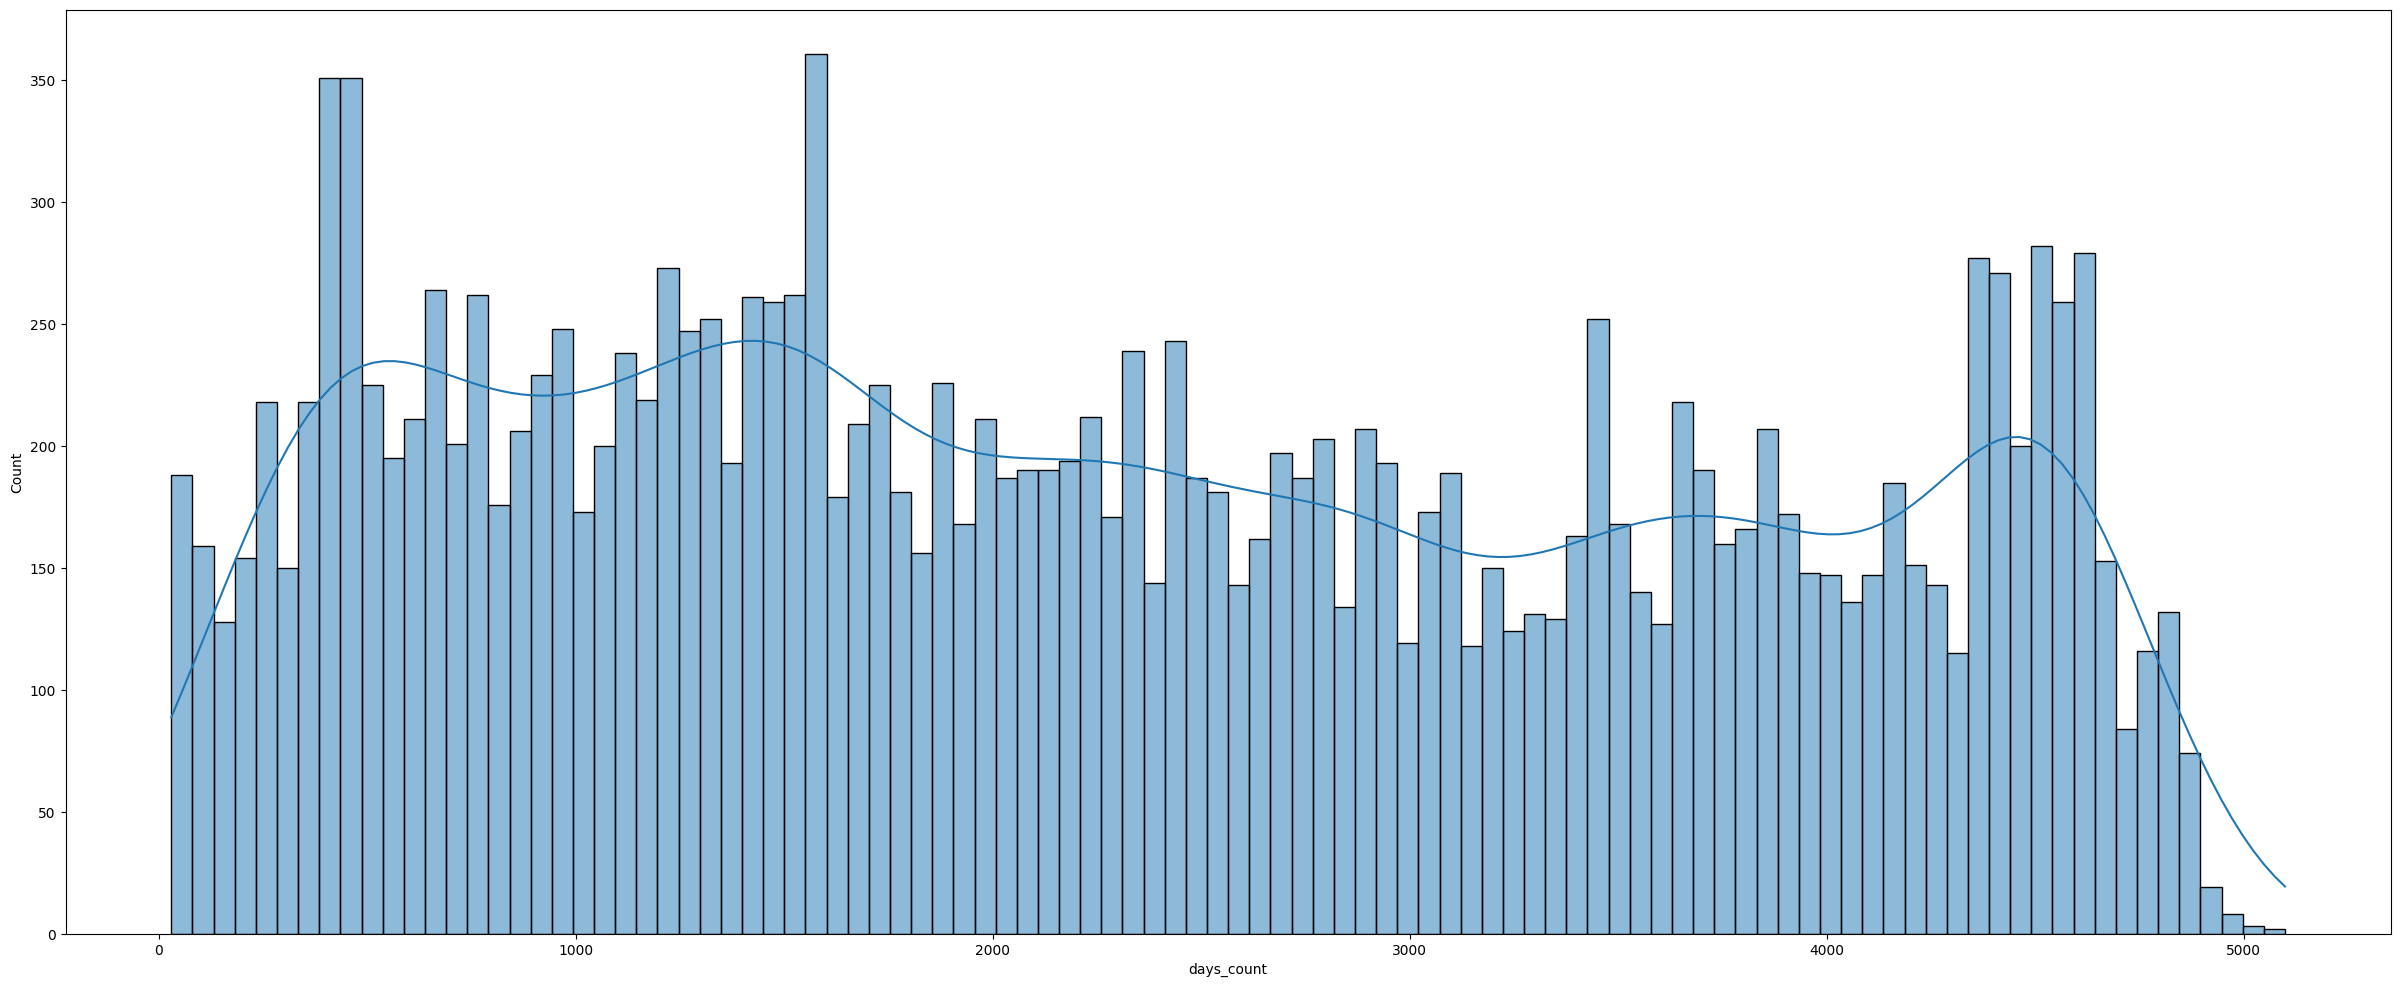

In [47]:
sns.histplot(data=games['days_count'], kde=True, bins=100)

In [48]:
games['days_count'].max()

5099

Одна из первых игр была создана на tesera.ru 5099 дней (14 лет) назад.

### корреляция данных

<AxesSubplot:>

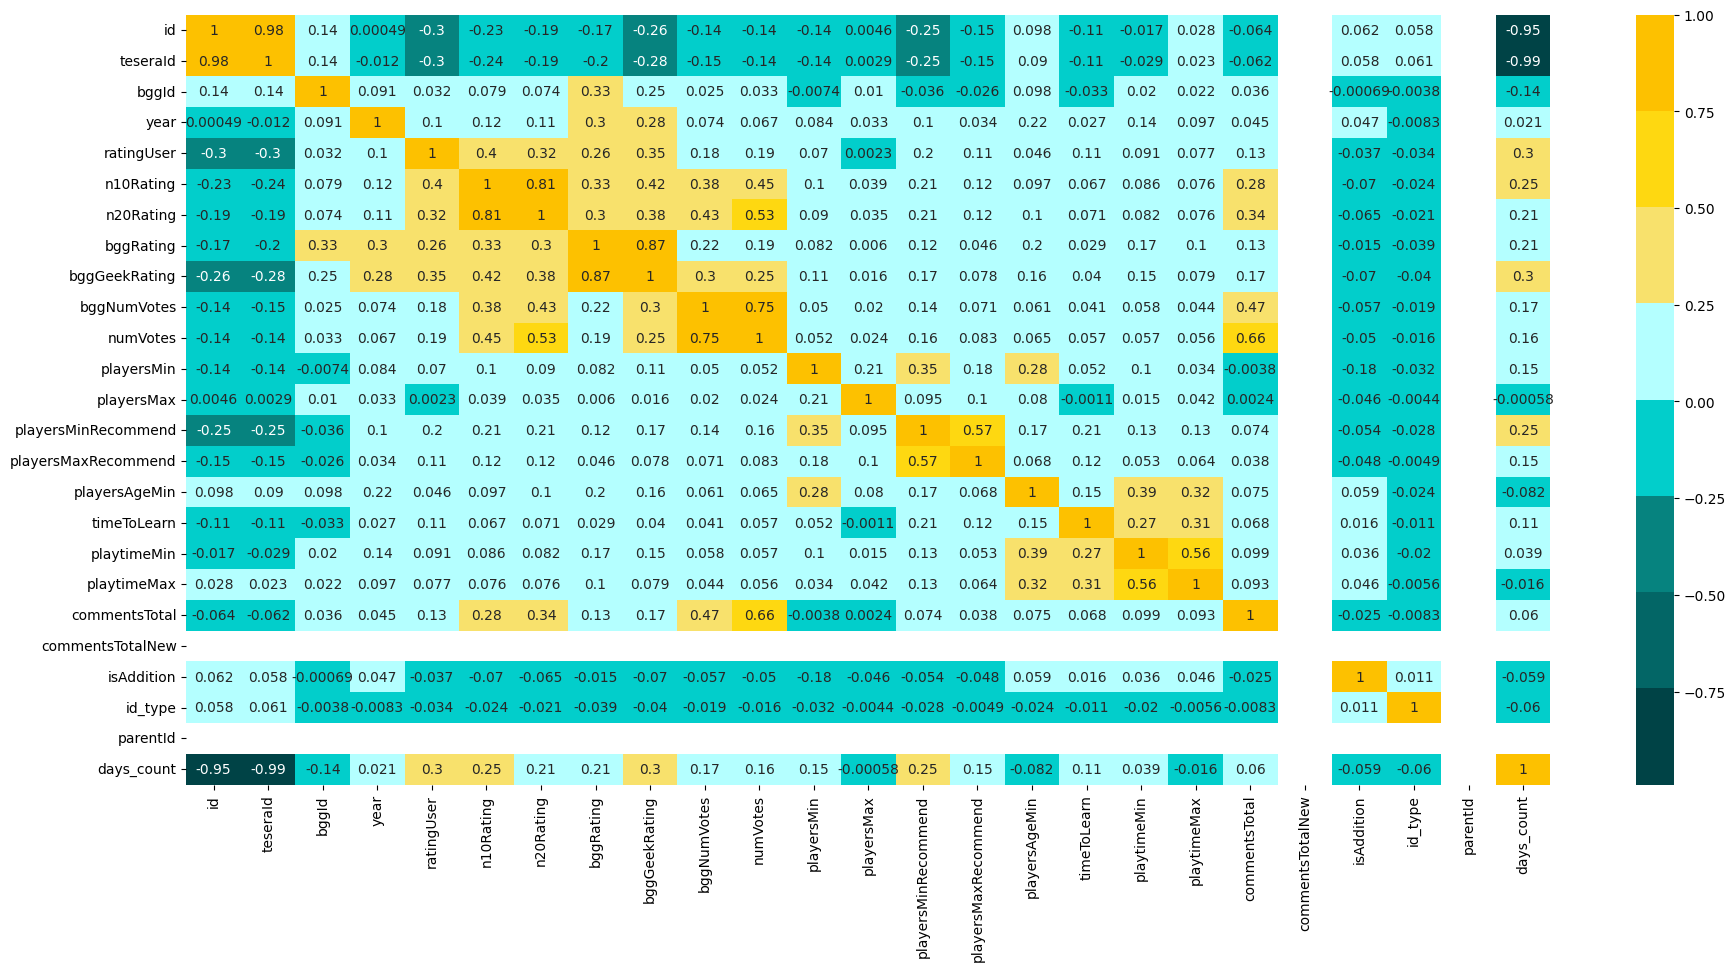

In [49]:
plt.figure(figsize=(22,10))
sns.heatmap(games.corr(), annot=True, 
            cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

В принципе ожидаемо связь видна только между связанными данными, например id и teseraid. 

### подготовка данных к обучению

In [50]:
games = games.drop(columns=['id', 'bggId', 'modificationDateUtc', 'photoUrl', 'parentId', 
                            'commentsTotalNew', 'title2', 'title3', 'id_type'])

In [51]:
df_content_based = games.copy()

In [52]:
df_content_based.dropna(subset=['descriptionShort', 'description'], inplace=True, axis=0)
df_content_based = df_content_based.reset_index(drop=True)
df_content_based.isna().sum()

teseraId               0
title                  0
alias                  0
descriptionShort       0
description            0
creationDateUtc        0
year                   0
ratingUser             0
n10Rating              0
n20Rating              0
bggRating              0
bggGeekRating          0
bggNumVotes            0
numVotes               0
playersMin             0
playersMax             0
playersMinRecommend    0
playersMaxRecommend    0
playersAgeMin          0
timeToLearn            0
playtimeMin            0
playtimeMax            0
commentsTotal          0
isAddition             0
name                   0
category               0
days_count             0
dtype: int64

# RECOMMENDER SYSTEMS

##  Content Based

Content based использует данные исключительно об элементах (item). Для этого нужно иметь минимальное представление о предпочтениях пользователей, чтобы затем рекомендовать новые элементы с тегами/ключевыми словами, аналогичными тем, которые указаны (или предполагаемы) пользователем. Довольно распространенным подходом к этой проблеме является использование векторизатора tf-idf. В проекте я буду использовать описание игр и категории.

In [53]:
# посмотрим какой текст содержит описание игры

df_content_based['description'].iloc[111]

'<p><i>Важно! Грани судьбы: Восстание - это дополнение к игре <a href="https://tesera.ru/game/dice-forge/" target="_blank" rel="noopener">Грани судьбы</a>.&nbsp;</i></p>\r\n<p>Модуль содержит некоторые игровые материалы (к примеру, карты подвигов которые должны быть использованы вместе.&nbsp; Каждый модуль предлагает новые игровые опции для еще более разнообразных игр.</p>\r\n<p>В модуле "Лабиринт богини" (4 связанных набора карт) вы познакомитесь с сильной богиней, которая готова бросить вызов другим богам. Она даст каждому из вас голема, чтобы направлять вас через лабиринт к чудесным&nbsp; сокровищам. Присоединившийся&nbsp; к ней получит много славы, но будьте осторожны, отрекаясь от других богов...</p>\r\n<p>В модуле "Восстание Титанов" (6 связанных наборов карт) наш турнир нарушается возвращением старых правителей небес.Титаны дадут вам доступ к своему источнику силы, если вы отвернетесь от богов. Время восстания пришло. Чью сторону вы примете?</p>\r\n<p>В начале игры определитесь 

In [54]:
# какой текст содержит краткое описание игры

df_content_based['descriptionShort'].iloc[111]

'Первое дополнение для настольной игры Dice Forge. Расширение состоит из двух частей, которые можно добавлять к основной игре. В общей сложности это 30 карт подвигов, а также новые грани кубов, новое поле и дополнительный органайзер со святилищем....'

необходимо очистить текст от лишних символов

In [55]:
# в description оставляю текст только на русском языке, так как много символов смешанных с английским

regex = re.compile('[^А-Яа-я]')
df_content_based['description'] = [regex.sub(' ', text).lower() for text in df_content_based['description']]


# в кратком описании и названии категорий удалю все символы

df_content_based['descriptionShort'] = [re.sub(r'[^\w\s]', ' ', t).lower() for t in df_content_based['descriptionShort']]
df_content_based['category']= [re.sub(r'[^\w\s]', ' ', tex).lower() for tex in df_content_based['category']]

[nltk_data] Downloading package stopwords to /Users/pgagp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


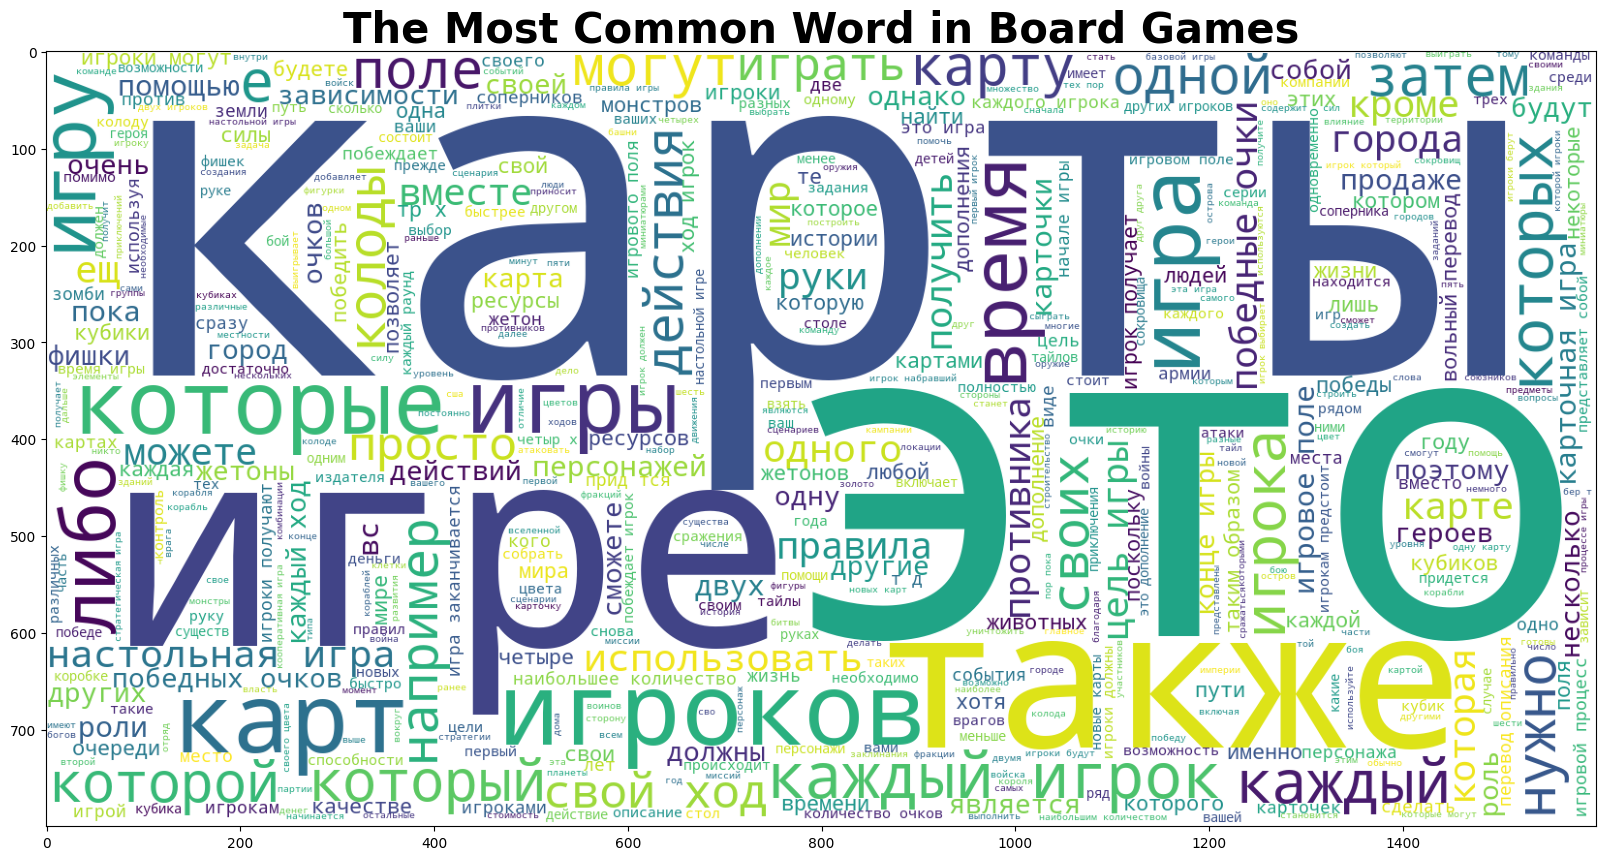

In [56]:
nltk.download('stopwords')
stopwords = list(stopwords.words('russian'))


plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Board Games', fontsize=30, weight=600)
wc = WordCloud(max_words=1000, min_font_size=10, background_color='white',
                height=800,width=1600, stopwords=stopwords).generate(' '.join(df_content_based['description']))

plt.imshow(wc)

In [57]:
# напишу функцию для лемматизации текста

nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()


def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

[nltk_data] Downloading package punkt to /Users/pgagp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pgagp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
# создаю новый столбец с объедененным текстом

df_content_based['common'] = (df_content_based['category'] + 
                              df_content_based['descriptionShort'] + 
                              df_content_based['description']).apply(lemmatize_text)

In [59]:
# что получилось

df_content_based['common'].iloc[111]

'азартные классика игральные кости карты кости фэнтезипервое дополнение для настольной игры dice forge расширение состоит из двух частей которые можно добавлять к основной игре в общей сложности это 30 карт подвигов а также новые грани кубов новое поле и дополнительный органайзер со святилищем важно грани судьбы восстание это дополнение к игре грани судьбы модуль содержит некоторые игровые материалы к примеру карты подвигов которые должны быть использованы вместе каждый модуль предлагает новые игровые опции для еще более разнообразных игр в модуле лабиринт богини связанных набора карт вы познакомитесь с сильной богиней которая готова бросить вызов другим богам она даст каждому из вас голема чтобы направлять вас через лабиринт к чудесным сокровищам присоединившийся к ней получит много славы но будьте осторожны отрекаясь от других богов в модуле восстание титанов связанных наборов карт наш турнир нарушается возвращением старых правителей небес титаны дадут вам доступ к своему источнику с

In [60]:
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(df_content_based['common'])
cosine_similarities = linear_kernel(matrix,matrix)

In [61]:
# Напишу функицю которая возвращает 15 наиболее похожих фильмов на основе оценки косинусного сходства.

game_title = df_content_based['title']
indices = pd.Series(df_content_based.index, index=df_content_based['title'])


def content_recommender(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:16]
    games_indices = [i[0] for i in sim_scores]
    return game_title.iloc[games_indices]

In [62]:
# посмотрим какие рекомендации получим на примере игры "Покорение марса"

content_recommender('Покорение Марса')

13250                               TINYforming Mars
4235     Terraforming Mars: Ares Expedition - Crisis
5270                                     Pocket Mars
1007                                           Ceres
11768                                       На Марсе
11509                 Tramways: Dystopian Expansions
1046                   Infinity Deathmatch: TAG Raid
5216                              Покорители космоса
11335                                Frozen Frontier
4581              Покорение Марса. Экспедиция «Арес»
9789                                      30 To Mars
6000                      Warhammer 40 000: Conquest
5616                       Helionox: The Last Sunset
1310                                  Climate Crisis
1703                                          LANDER
Name: title, dtype: object

В целом довольно наивный рекомендатель, основанный на содержании, может дать неплохие результаты. 

## Collaborative Filtering

Чтобы устранить некоторые ограничения content based recsys, совместная фильтрация одновременно использует сходство между пользователями и элементами для предоставления рекомендаций. Это позволяет давать качественные рекомендации, то есть модели совместной фильтрации могут рекомендовать элемент пользователю A на основе интересов аналогичного пользователя B.

Для проекта я буду сторить модель с помощью turicreate, которая ранжирует элемент в соответствии с его сходством с другими элементами, наблюдаемыми для рассматриваемого пользователя. Сначала вычисляется сходство между элементами, используя наблюдения пользователей, которые взаимодействовали с обоими элементами.

In [63]:
# преобразую категориальные данные с помощью кодировки

encoded_cols = pd.get_dummies(games['name'])

In [64]:
df_turi = games.copy()
df_turi = df_turi.join(encoded_cols)

In [65]:
df_turi.columns

Index(['teseraId', 'title', 'alias', 'descriptionShort', 'description',
       'creationDateUtc', 'year', 'ratingUser', 'n10Rating', 'n20Rating',
       'bggRating', 'bggGeekRating', 'bggNumVotes', 'numVotes', 'playersMin',
       'playersMax', 'playersMinRecommend', 'playersMaxRecommend',
       'playersAgeMin', 'timeToLearn', 'playtimeMin', 'playtimeMax',
       'commentsTotal', 'isAddition', 'name', 'category', 'days_count',
       'Азартные', 'Война', 'Карты', 'Классика', 'Компанейские', 'Логические',
       'Приключения', 'Экономика', 'абстрактная', 'арабская',
       'бизнес / промышленность', 'вампиры', 'восточная', 'вторая мировая',
       'дикий запад', 'динозавры', 'древний мир', 'животные / природа',
       'зомби', 'изобретения', 'инопланетяне', 'историческая', 'киберпанк',
       'кино и ТВ', 'компьютеры', 'космос', 'криминал', 'культура / искусство',
       'магия', 'медицина', 'микромир', 'монстры', 'морское / водное',
       'пещерный век', 'пираты', 'политика', 'постап

In [66]:
# удаляю ненужные стообцы

df_turi = df_turi.drop(columns=['descriptionShort', 'description', 'n10Rating', 'n20Rating',
                               'bggGeekRating', 'playersMinRecommend', 'playersMaxRecommend', 
                               'numVotes', 'timeToLearn', 'name', 'category'])

In [67]:
# выбираю столбцы с числовыми данными для масштабирования данных

cols = ['year', 'ratingUser',
       'bggRating', 'bggNumVotes', 'playersMin', 'playersMax', 
       'playersAgeMin', 'playtimeMin', 'playtimeMax']

In [68]:
# масштабирую с помощью StandardScaler
st_df = df_turi[cols]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(st_df)

df_turi[cols] = scaled_data

In [69]:
# для матрицы обратной связи user - item, копирую датасет с юзерами и переименую столбцы для удобства

turi_users = users.copy()
turi_users = turi_users.rename(columns={'game_alias': 'alias'})

sf = turi_users[['author.teseraId', 'alias', 'rating']]
sf = sf.rename(columns={'author.teseraId':'user_id', 'alias':'item_id'})

In [70]:
# Привожу датафрейм к сфрейм для работы с библиотекой Turi create

sf = SFrame(data=sf)

In [71]:
# выбраю стобцы с данныии о пользователях
user_info = turi_users[['author.teseraId', 'author.rating']]

# выбраю стобцы с доп. данныии об играх
item_info = df_turi.drop(columns=['creationDateUtc'])

In [72]:
user_info = user_info.rename(columns={'author.teseraId':'user_id'})
item_info = item_info.rename(columns={'alias':'item_id'})

user_info = SFrame(data=user_info)
item_info = SFrame(data=item_info)

In [73]:
# Метрика сходства - pearson
# seed_item_set_size = 0 Для пользователей, которые еще не оценили какие-либо элементы 
# или оценили только уникальные элементы без информации о похожих элементах, 
# модель заполняет набор элементов пользователя средними оценками наиболее популярных элементов 


model = tc.item_similarity_recommender.create(sf, target='rating',
                                                   user_id='user_id', item_id='item_id',
                                                   user_data=user_info,
                                                   item_data=item_info,
                                                   similarity_type='pearson',
                                                  seed_item_set_size = 0,
                                                  verbose=False)

In [74]:
model.get_similar_items(SArray(data=['terraforming-mars']))

item_id,similar,score,rank
terraforming-mars,wingspan,0.2188866138458252,1
terraforming-mars,Mombasa,0.2080870270729065,2
terraforming-mars,Viticulture-Essential-Edition ...,0.19666314125061035,3
terraforming-mars,viticulture-essential-edition ...,0.19666314125061035,4
terraforming-mars,twilight-struggle,0.1894034743309021,5
terraforming-mars,scythe,0.1858288049697876,6
terraforming-mars,die-burgen-von-burgund,0.18408089876174927,7
terraforming-mars,Vremena-i-Epohi-Smuta,0.18178266286849976,8
terraforming-mars,Eldritch-Horror,0.1816076636314392,9
terraforming-mars,Tyrants-of-the-Underdark,0.1784365177154541,10


In [75]:
model.summary()

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : user_id
Item ID                          : item_id
Target                           : rating
Additional observation features  : 0
User side features               : ['user_id', 'author.rating']
Item side features               : ['teseraId', 'title', 'item_id', 'year', 'ratingUser', 'bggRating', 'bggNumVotes', 'playersMin', 'playersMax', 'playersAgeMin', 'playtimeMin', 'playtimeMax', 'commentsTotal', 'isAddition', 'days_count', 'Азартные', 'Война', 'Карты', 'Классика', 'Компанейские', 'Логические', 'Приключения', 'Экономика', 'абстрактная', 'арабская', 'бизнес / промышленность', 'вампиры', 'восточная', 'вторая мировая', 'дикий запад', 'динозавры', 'древний мир', 'животные / природа', 'зомби', 'изобретения', 'инопланетяне', 'историческая', 'киберпанк', 'кино и ТВ', 'компьютеры', 'космос', 'криминал', 'культура / искусство', 'магия', 'медицина', 'микромир', 'монстры', 'морское /

In [76]:
# сохраняю модель для создания вебапп
# model.save('model_turi')

В целом модель показала хорошие результаты.

###### ВЫВОД

Преимуществом рекомендаций на основе контента является то, что они не страдают от проблемы холодного старта, поскольку нужна только основная информация о юзере (в данном случае лишь одна игра), чтобы предоставить аналогичные рекомендации на основе элементов. Однако важным недостатком является то, что он имеет тенденцию рекомендовать элементы одного и того же типа. Эту уязвимость хорошо решает совместная фильтрация, которая позволяет пользователям открыть для себя новые интересы. В изоляции система машинного обучения может не знать, что пользователь заинтересован в данном элементе, но модель все же может рекомендовать его, поскольку похожие пользователи заинтересованы в этом элементе.